### Daten erzeugen

X ist eine bivariate Gauss Verteilung.
y ist eine lineare Transformation der ersten Koordinate, mit Noise



In [91]:
import numpy as np

def generate_without_missing_values(n_samples, rng=42):
    mean = [0, 0]
    cov = [[1, 0.9], [0.9, 1]]
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)
    X = rng.multivariate_normal(mean, cov, size=n_samples)

    epsilon = 0.1 * rng.randn(n_samples)
    y = X[:, 0] + epsilon

    return X, y

### Plot der Daten

Jede Zeile von X gibt ein Punkt. y gibt die Färbung


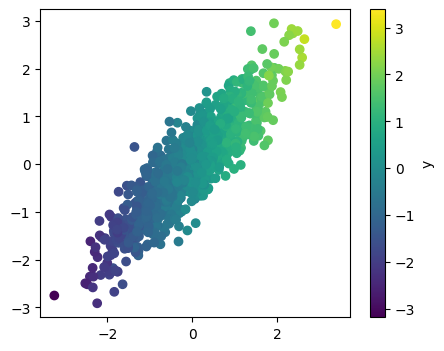

In [92]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4) # Smaller default figure size

plt.figure()
X_full, y_full = generate_without_missing_values(1000)
plt.scatter(X_full[:, 0], X_full[:, 1], c=y_full)
plt.colorbar(label='y')

### Missing completely at random 

Wir entfernen jetzt zufällig Daten


In [93]:
def generate_mcar(n_samples, missing_rate=.2, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    M = rng.binomial(1, missing_rate, (n_samples, 2))
    X_mcar = X_full.copy()
    np.putmask(X_mcar, M, np.nan)

    return X_full, X_mcar, y

Plot der Daten mit missing values

Fehlende Werte sind grau.



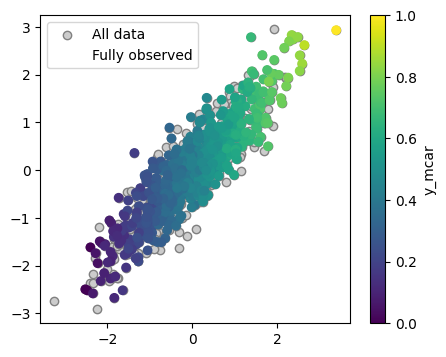

In [94]:
X_full, X_mcar, y_mcar = generate_mcar(1000)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mcar')
plt.scatter(X_mcar[:, 0], X_mcar[:, 1], c=y_mcar, label='Fully observed')
plt.legend()

### Not missing at random

Größere Werte fehlen eher als kleiner



In [95]:
def generate_censored(n_samples, missing_rate=.4, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    B = rng.binomial(1, 2 * missing_rate, (n_samples, 2))
    M = (X_full > 0.5) * B
    
    X_nmar = X_full.copy()
    np.putmask(X_nmar, M, np.nan)

    return X_full, X_nmar, y

Wieder ein Plot


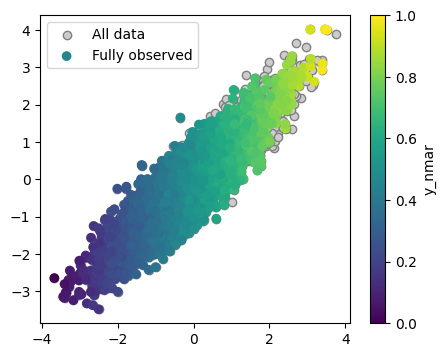

In [96]:
X_full, X_nmar, y_nmar = generate_censored(10000, missing_rate=.2)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data')
plt.colorbar(label='y_nmar')
plt.scatter(X_nmar[:, 0], X_nmar[:, 1], c=y_nmar, label='Fully observed')
plt.legend()

## Aufgaben

- MAR
    - Wandeln Sie die Funktion ```generate_mcar``` so ab, dass die Daten statt *missing completely at random* nur noch die Bedingung *missing at random* erfüllen.


- Auffüllen
    - Füllen Sie in beiden Fällen die Daten mit einem Iterativen Imputen auf
    - Füllen Sie in beiden Fällen die Daten mit einem SimpleImputer (z.Bsp. dem mean) auf
    - Visualisieren Sie die aufgefüllten Daten

- Modell trainieren
    - Trainieren Sie eine lineare Regression auf den aufgefüllten Daten und vergleichen Sie die Ergebnisse mit einer 10-fachen Kreuzvalidierung
    - Trainieren Sie zum Vergleich ein Modell mit ```HistGradientBoostingRegressor```. Dieses Modell kann mit fehlenden Werten umgehen.

- Mehr Daten
    - Erhöhen Sie die Datenmenge auf 10000 Punkte und vergleichen Sie wieder die Ergebnisse

```python
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
```



In [7]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

MAR
    - Wandeln Sie die Funktion ```generate_mcar``` so ab, dass die Daten statt *missing completely at random* nur noch die Bedingung *missing at random* erfüllen.

In [97]:
def generate_mar(n_samples, missing_rate=.2, rng=42):
    X_full, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    # Generate a mask for missing values based on the values of other columns
    mask = np.zeros(X_full.shape, dtype=bool)
    
    # Missing values in the first column depend on the values in the second column
    prob_1 = missing_rate * (X_full[:, 1] - X_full[:, 1].min()) / (X_full[:, 1].max() - X_full[:, 1].min())
    mask[:, 0] = rng.rand(n_samples) < prob_1
    
    # Missing values in the second column depend on the values in the first column
    prob_2 = missing_rate * (X_full[:, 0] - X_full[:, 0].min()) / (X_full[:, 0].max() - X_full[:, 0].min())
    mask[:, 1] = rng.rand(n_samples) < prob_2
    
    X_mar = X_full.copy()
    X_mar[mask] = np.nan

    return X_full, X_mar, y



Füllen Sie in beiden Fällen die Daten mit einem Iterativen Imputen auf

In [126]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.experimental import enable_iterative_imputer  # Diesen Import hinzufügen
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import   LinearRegression     


iterative_linear=make_pipeline(IterativeImputer(),LinearRegression())


In [99]:
from sklearn import model_selection

scores_iterative_linear_mcar = model_selection.cross_val_score(iterative_linear,X_mcar,y_mcar, cv=10)

scores_iterative_linear_mcar

array([0.88434804, 0.9032118 , 0.90165688, 0.90217809, 0.938353  ,
       0.85448266, 0.93217221, 0.8997615 , 0.89068757, 0.94977381])

In [127]:
scores_iterative_linear_mar = model_selection.cross_val_score(iterative_linear,X_mar,y_mar, cv=10)

scores_iterative_linear_mar

array([0.93007425, 0.97128824, 0.93080525, 0.95127558, 0.94950653,
       0.97232224, 0.96168168, 0.973029  , 0.97601816, 0.944298  ])

Füllen Sie in beiden Fällen die Daten mit einem SimpleImputer (z.Bsp. dem mean) auf


In [129]:
imput = SimpleImputer(strategy="mean")
x_mcar_imputed =imput.fit_transform(X_mcar)
x_mar_imputed = imput.fit_transform(X_mar)


In [122]:
x_mar_imputed

array([[-0.45322023, -0.51505391],
       [-0.97184853, -0.29072887],
       [ 0.28057909,  0.17586986],
       ...,
       [-0.58184221, -0.05423574],
       [ 0.22304289, -0.05423574],
       [ 0.32550331, -0.00762728]])

In [121]:
x_mcar_imputed

array([[-0.45322023, -0.00196758],
       [-0.97184853, -0.29072887],
       [ 0.28057909,  0.17586986],
       ...,
       [-0.58184221, -0.10325647],
       [-0.02781412, -0.17134344],
       [ 0.32550331, -0.00762728]])

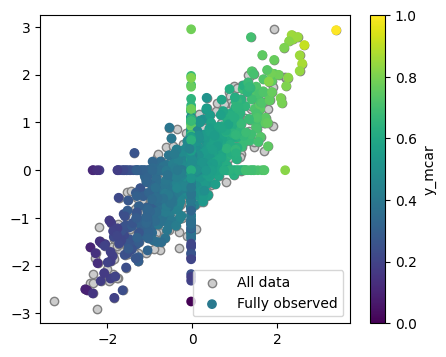

In [130]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mcar')
plt.scatter(x_mcar_imputed[:, 0], x_mcar_imputed[:, 1], c=y_mcar, label='Fully observed')
plt.legend()

In [145]:
X_full, X_mar, y_mar = generate_mar (1000)

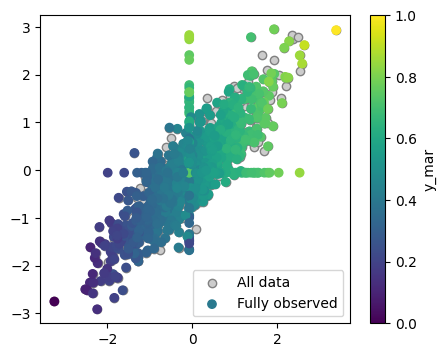

In [132]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mar')
plt.scatter(x_mar_imputed[:, 0], x_mar_imputed[:, 1], c=y_mar, label='Fully observed')
plt.legend()

 Trainieren Sie eine lineare Regression auf den aufgefüllten Daten und vergleichen Sie die Ergebnisse mit einer 10-fachen Kreuzvalidierung

In [133]:
# Lineare Regression erstellen und trainieren mcar 
regressor = LinearRegression()
regressor.fit(x_mcar_imputed,y_mcar)

# Kreuzvalidierung durchführen
cv_scores = cross_val_score(regressor, x_mcar_imputed, y_mcar, cv=10, scoring='r2')

# Ergebnisse anzeigen
print("Cross-validation scores (R^2):", cv_scores)
print("Durchschnittlicher R^2 Score:", np.mean(cv_scores))

Cross-validation scores (R^2): [0.87517485 0.81770606 0.81466168 0.87041509 0.86353057 0.77621722
 0.83960347 0.82841362 0.83176294 0.87604177]
Durchschnittlicher R^2 Score: 0.8393527270572297


In [134]:
# Lineare Regression erstellen und trainieren mar 
regressor = LinearRegression()
regressor.fit(x_mar_imputed, y_mar)

# Kreuzvalidierung durchführen
cv_scores = cross_val_score(regressor, x_mar_imputed, y_mar, cv=10, scoring='r2')

# Ergebnisse anzeigen
print("Cross-validation scores (R^2):", cv_scores)
print("Durchschnittlicher R^2 Score:", np.mean(cv_scores))

Cross-validation scores (R^2): [0.85297346 0.94622686 0.87128662 0.8761778  0.90204604 0.92915624
 0.91887332 0.93712661 0.89751296 0.91216284]
Durchschnittlicher R^2 Score: 0.904354275988433


Trainieren Sie zum Vergleich ein Modell mit ```HistGradientBoostingRegressor```. Dieses Modell kann mit fehlenden Werten umgehen.

In [150]:
from sklearn.ensemble import GradientBoostingRegressor
hgbr = HistGradientBoostingRegressor()
cv_scores = cross_val_score(hgbr,X_mar,y_mar,cv=10)

In [154]:
cv_scores.mean()

0.8967616664562701

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
hgbr = HistGradientBoostingRegressor()
cv_scores = cross_val_score(hgbr,X_mcar,y_mcar,cv=10)

In [155]:
cv_scores.mean()

0.8967616664562701

Erhöhen Sie die Datenmenge auf 10000 Punkte und vergleichen Sie wieder die Ergebnisse


In [158]:
X_full, X_mcar, y_mcar = generate_mcar(10000)
X_full, X_mar, y_mar = generate_mar (10000)

In [159]:
imput = SimpleImputer(strategy="mean")
x_mcar_imputed =imput.fit_transform(X_mcar)
x_mar_imputed = imput.fit_transform(X_mar)

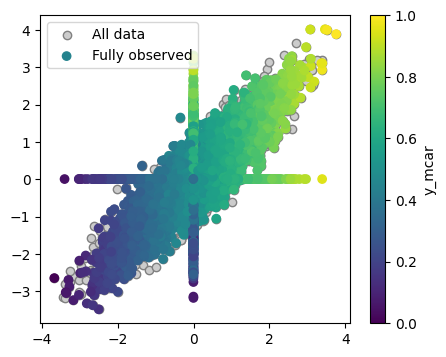

In [160]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mcar')
plt.scatter(x_mcar_imputed[:, 0], x_mcar_imputed[:, 1], c=y_mcar, label='Fully observed')
plt.legend()

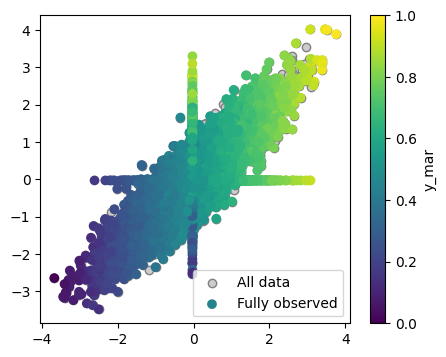

In [161]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y_mar')
plt.scatter(x_mar_imputed[:, 0], x_mar_imputed[:, 1], c=y_mar, label='Fully observed')
plt.legend()

In [162]:
# Lineare Regression erstellen und trainieren mcar 
regressor = LinearRegression()
regressor.fit(x_mcar_imputed,y_mcar)

# Kreuzvalidierung durchführen
cv_scores = cross_val_score(regressor, x_mcar_imputed, y_mcar, cv=10, scoring='r2')

# Ergebnisse anzeigen
print("Cross-validation scores (R^2):", cv_scores)
print("Durchschnittlicher R^2 Score:", np.mean(cv_scores))

Cross-validation scores (R^2): [0.84381682 0.83831257 0.86247372 0.82258282 0.83713454 0.83358707
 0.85650637 0.84722086 0.84377518 0.83254996]
Durchschnittlicher R^2 Score: 0.8417959903977378


In [163]:
# Lineare Regression erstellen und trainieren mar 
regressor = LinearRegression()
regressor.fit(x_mar_imputed, y_mar)

# Kreuzvalidierung durchführen
cv_scores = cross_val_score(regressor, x_mar_imputed, y_mar, cv=10, scoring='r2')

# Ergebnisse anzeigen
print("Cross-validation scores (R^2):", cv_scores)
print("Durchschnittlicher R^2 Score:", np.mean(cv_scores))

Cross-validation scores (R^2): [0.91133132 0.89092752 0.91257581 0.9072737  0.92533553 0.91859625
 0.92489558 0.93102268 0.91706355 0.91903367]
Durchschnittlicher R^2 Score: 0.9158055616897842
